## Preamble



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
import pandas as pd
import numpy as np
from IPython.display import HTML, display
import tabulate

## Systematics from minimization



Simulations are all the same (seed is 31415) and we estimate the intrinsic variance on
cosmo. parameters *i.e.* the systematics from minimization from 100 simulations



In [1]:
def get_params(path, pattern="*.likelihood"):
    import os, glob
    all_files = glob.glob(os.path.join(path, pattern))
    # Sort alphabetically
    all_files.sort()

    header = pd.read_csv(all_files[0], delim_whitespace=True).columns[1:]
    df = pd.concat((pd.read_table(f, delim_whitespace=True) for f in all_files))

    # Remove '#' in header
    df.drop(df.columns[[-1,]], axis=1, inplace=True)
    df.columns = header
    df.insert(value=df.chi2/2/1944, column="chi2_ndf", loc=7)
    params = np.array(df.iloc[:, 2:8])
    return params

In [1]:
params = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/100_sims_syst")

In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$A_\mathrm{s}$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\chi^2/\mathrm{ndf}$"]
min_mean = np.mean(params, axis=0)
min_std  = np.std(params, axis=0)
lines = [[r"$\mu$"], [r"$\sigma$"]]
table = np.stack([min_mean, min_std])
table = np.append(lines, table, axis=1)

In [1]:
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

## Compare sucessfull and unsucessful minimization



### Parse qsub output file



In [1]:
import os, glob

path =r"/home/garrido/Workdir/CMB/analysis/beyondCV/script/ell_50_2000"
all_files = glob.glob(os.path.join(path, "*.o*"))

chi2_theory = []
chi2_begin  = []
chi2_end    = []
success     = []
surveys     = []
start_time  = []
stop_time   = []
seeds       = []

def date2time(line):
    time = line.split(" ", maxsplit=3)[-1]
    time = time[:-5].strip()
    return pd.to_datetime(time, format="%c")

for f in all_files:
    find_begin = False
    success += [False]
    chi2_end += [0]
    with open(f) as stream:
        for line in stream:
            if "DEBUG: seed" in line:
                seeds += [line.split("=")[1].strip()]
            if "DEBUG: survey" in line:
                survey = line.split("=")[1].strip()
                if survey == "SO" or survey == "P":
                  survey += "x" + survey
                surveys += [survey]
            if "chi2(theo)/ndf" in line:
                if survey in line:
                    chi2_theory += [float(line.split("=")[1].strip())]
            if "chi2/ndf" in line:
                if not find_begin:
                    chi2_begin += [float(line.split("=")[1].strip())]
                    find_begin = True
                chi2_end[-1] = float(line.split("=")[1].strip())
            if "Finished succesfully." in line:
                success[-1] = True
            if "Started on" in line:
                start_time += [date2time(line)]
            if "Ended on" in line:
                stop_time += [date2time(line)]
print("INFO: Read {} files".format(len(all_files)))

### Convert =list= into =pandas.DataFrame=



In [1]:
df = pd.DataFrame({"duration": np.array(stop_time)-np.array(start_time),
                   "chi2_theory": chi2_theory,
                   "chi2_begin": chi2_begin,
                   "chi2_end": chi2_end,
                   "success": success,
                   "survey": surveys},
                  index=np.array(seeds, dtype=np.uint))
df.sort_index(inplace=True)
df.head()

# Out[9]:
#+BEGIN_EXAMPLE
  duration  chi2_theory  chi2_begin  chi2_end  success survey
  28 00:28:50     0.972313    3.095984  0.969023    False    PxP
  28 00:16:03     1.005701    3.393066  1.004198     True  SOxSO
  28 00:38:43     0.974076    3.282166  0.972015    False   SOxP
  73 00:27:50     0.960580    2.186273  0.959675    False  SOxSO
  73 00:11:16     0.969954    2.142016  0.969248     True   SOxP
#+END_EXAMPLE

### Get duration statistics



In [1]:
df.duration.describe()

# Out[10]:
#+BEGIN_EXAMPLE
  count                      3003
  mean     0 days 00:20:38.789543
  std      0 days 00:08:35.697947
  min             0 days 00:03:56
  25%             0 days 00:14:32
  50%             0 days 00:19:39
  75%             0 days 00:25:26
  max             0 days 01:47:28
  Name: duration, dtype: object
#+END_EXAMPLE

### Get number of sucessfull minimization



In [1]:
np.sum(df.success)

# Out[11]:
1907

How many minimizations succeed for the three configurations *i.e.* SOxSO, SOxP, PxP



In [1]:
dff = df.groupby(df.index).success.describe()
np.sum((dff.top == True) & (dff.freq == 3)), \
np.sum((dff.top == False) & (dff.freq == 3))

# Out[12]:
(252, 51)

#### Plot distribution of $\chi^2$ between successfull and unsuccessful minimizations



In [1]:
import seaborn as sb

# Out[14]:

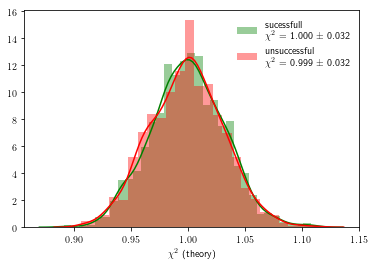

In [1]:
tmpl="{}\n$\chi^2$ = {:.3f} $\pm$ {:.3f}"
df1 = df.chi2_theory[df.success]
df2 = df.chi2_theory[~df.success]
sb.distplot(df1, label=tmpl.format("sucessfull",np.mean(df1),np.std(df1)), color="green", axlabel=r"$\chi^2$ (theory)")
sb.distplot(df2, label=tmpl.format("unsuccessful",np.mean(df2), np.std(df2)), color="red", axlabel=r"$\chi^2$ (theory)")
plt.legend()

# Out[15]:

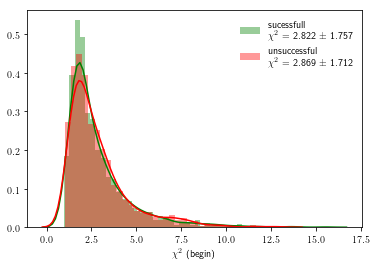

In [1]:
tmpl="{}\n$\chi^2$ = {:.3f} $\pm$ {:.3f}"
df1 = df.chi2_begin[df.success]
df2 = df.chi2_begin[~df.success]
sb.distplot(df1, label=tmpl.format("sucessfull",np.mean(df1),np.std(df1)), color="green", axlabel=r"$\chi^2$ (begin)")
sb.distplot(df2, label=tmpl.format("unsuccessful",np.mean(df2),np.std(df2)), color="red", axlabel=r"$\chi^2$ (begin)")
plt.legend()

# Out[16]:

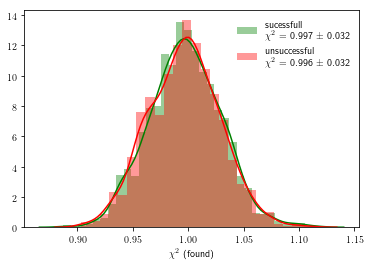

In [1]:
tmpl="{}\n$\chi^2$ = {:.3f} $\pm$ {:.3f}"
df1 = df.chi2_end[df.success]
df2 = df.chi2_end[~df.success]
sb.distplot(df1, label=tmpl.format("sucessfull",np.mean(df1),np.std(df1)), color="green", axlabel=r"$\chi^2$ (found)")
sb.distplot(df2, label=tmpl.format("unsuccessful",np.mean(df2),np.std(df2)), color="red", axlabel=r"$\chi^2$ (found)")
plt.legend()

## Profiles



Build dictionnary of parameters and associated column in `OptmizeResult` object



In [1]:
parnames = {
    "cosmomc_theta" : {"latex": r"$\theta_\mathrm{MC}$", "col": 0},
    "logA" : {"latex": r"$\log(10^{10}A_\mathrm{s})$", "col": 1},
    "ns" : {"latex": r"$n_\mathrm{s}$", "col": 2},
    "ombh2" : {"latex": r"$\Omega_\mathrm{b}h^2$", "col": 3},
    "omch2" : {"latex": r"$\Omega_\mathrm{c}h^2$", "col": 4},
}

Get params from `pickle` object



In [1]:
def get_params(path, pattern="*.pkl", parname=None):
    import os, glob
    all_files = glob.glob(os.path.join(path, pattern))

    chi2s = np.empty(len(all_files))
    values = np.empty(len(all_files))
    success = np.empty(len(all_files))
    import pickle
    for i, f in enumerate(all_files):
        results = pickle.load(open(f, "rb"))

        # Get optimization results
        opt_result = results.get("results").get("OptimizeResult")
        par = results.get("setup").get("cobaya").get("params").get(parname)
        if isinstance(par, float):
            values[i] = par
        elif par.get("value"):
            values[i] = par.get("value")
        else:
            col = int(parnames[parname]["col"])
            values[i] = opt_result.get("x")[col]
        chi2s[i] = opt_result.get("fun")
        success[i] = False if "failed" in opt_result.get("message") else True
    arr = np.array([values, chi2s, success]).transpose()
    return pd.DataFrame(arr, columns=["val", "chi2", "ok"])

Plot everything together



# Out[28]:

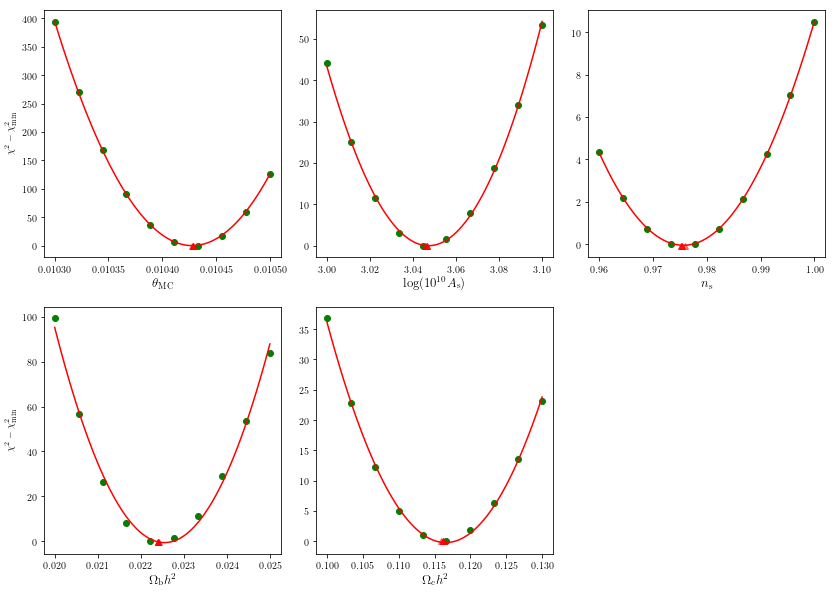

In [1]:
plt.figure(figsize=(14, 10))
for i, par in enumerate(parnames):
  params = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/profile", "*_{}_*.pkl".format(par), par)
  good = (params.ok == True)

  df = params.groupby("val").min()
  chi2_min = np.min(df.chi2)
  plt.subplot(2, 3, i+1)
  plt.plot(df.index, df.chi2-chi2_min, "og")
  mins = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/profile", "*maximum_[0-9]*.pkl", par)
  plt.plot(mins.val, mins.chi2-chi2_min, "^r", alpha=0.5)

  # Fit with a 2nd order polynomial
  p = np.poly1d(np.polyfit(df.index, df.chi2-chi2_min, 2))
  x = np.linspace(df.index[0], df.index[-1], 100)
  plt.plot(x, p(x), "-r")
  plt.xlabel(parnames[par]["latex"], fontsize=13)
  if not i%3:
    plt.ylabel(r"$\chi^2-\chi^2_\mathrm{min}$")
  # else:
    # plt.gca().set_yticklabels([])
plt.subplots_adjust(hspace=0.2, wspace=0.15)